
 The Highest & lowest cities as per co
 {'highest_city': "Nouvelle Pharmacie M'Pouto", 'highest_value': np.float64(0.29375), 'lowest_city': 'SunuAir ', 'lowest_value': np.float64(0.0)}

 The Highest & lowest cities as per no2
 {'highest_city': "Nouvelle Pharmacie M'Pouto", 'highest_value': np.float64(27.625), 'lowest_city': 'SunuAir ', 'lowest_value': np.float64(0.0)}

 The Highest & lowest cities as per o3
 {'highest_city': "Nouvelle Pharmacie M'Pouto", 'highest_value': np.float64(81.9375), 'lowest_city': 'SunuAir ', 'lowest_value': np.float64(0.0)}

 The Highest & lowest cities as per pm1
 {'highest_city': "Divine healer's Church, Bethlehem", 'highest_value': np.float64(22.96488093113413), 'lowest_city': "Nouvelle Pharmacie M'Pouto", 'lowest_value': np.float64(0.0)}

 The Highest & lowest cities as per pm10
 {'highest_city': "Nouvelle Pharmacie M'Pouto", 'highest_value': np.float64(39.5), 'lowest_city': 'SunuAir ', 'lowest_value': np.float64(0.0)}

 The Highest & lowest cities as pe

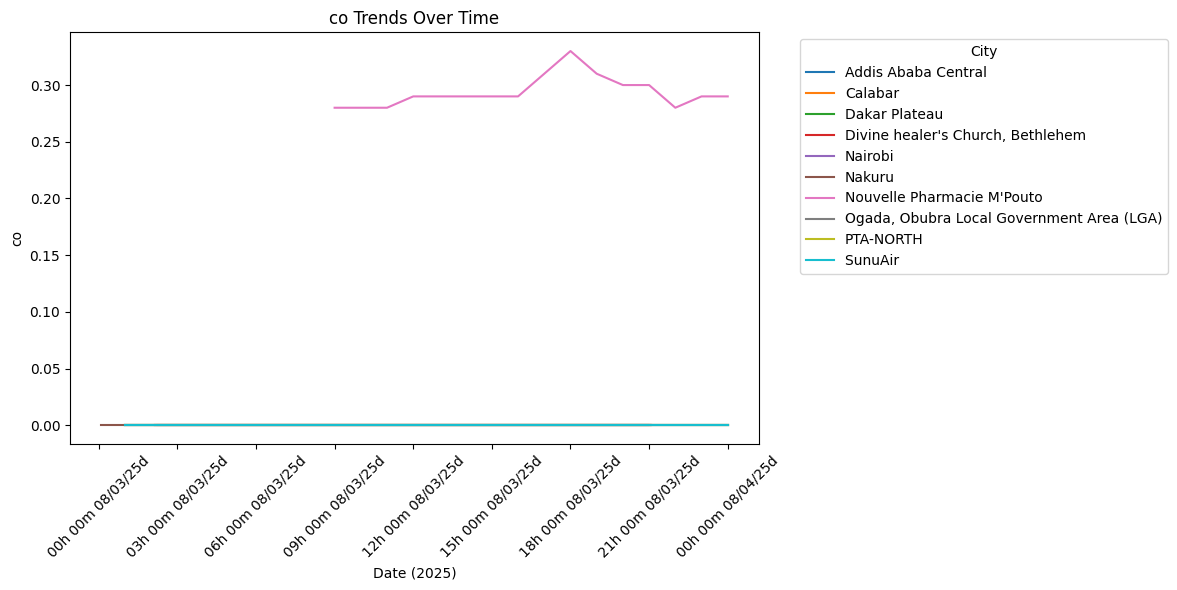

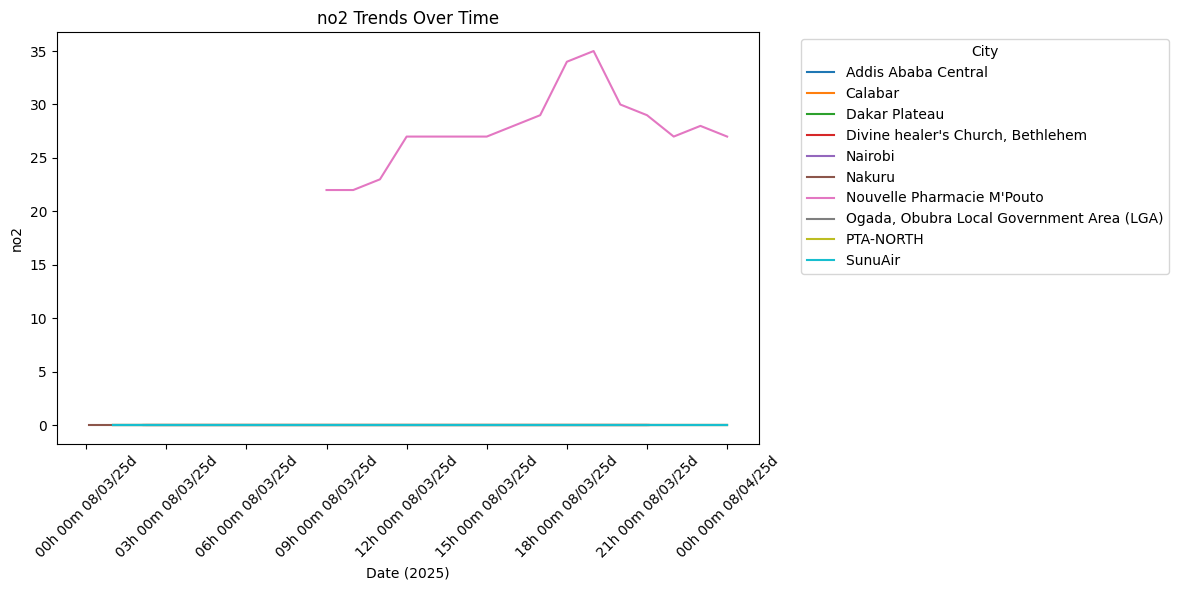

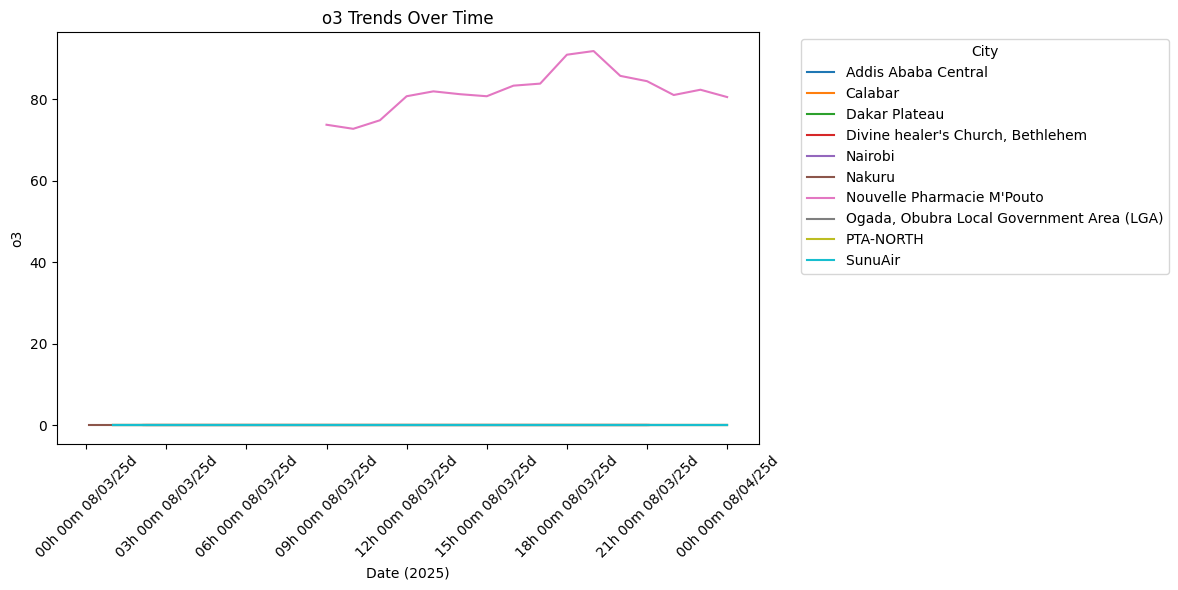

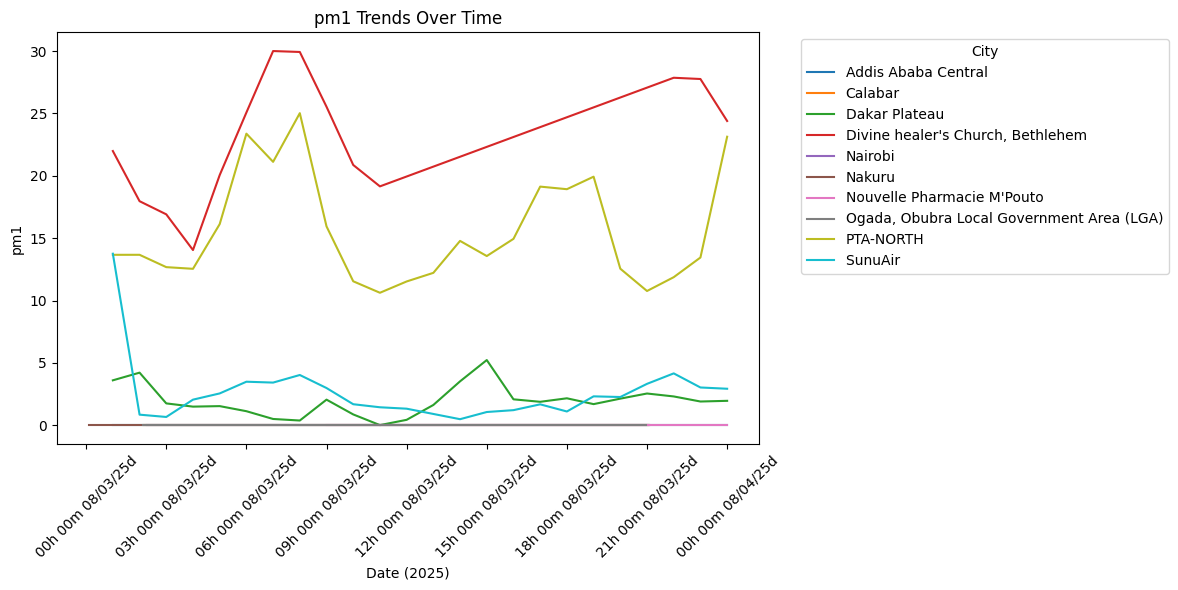

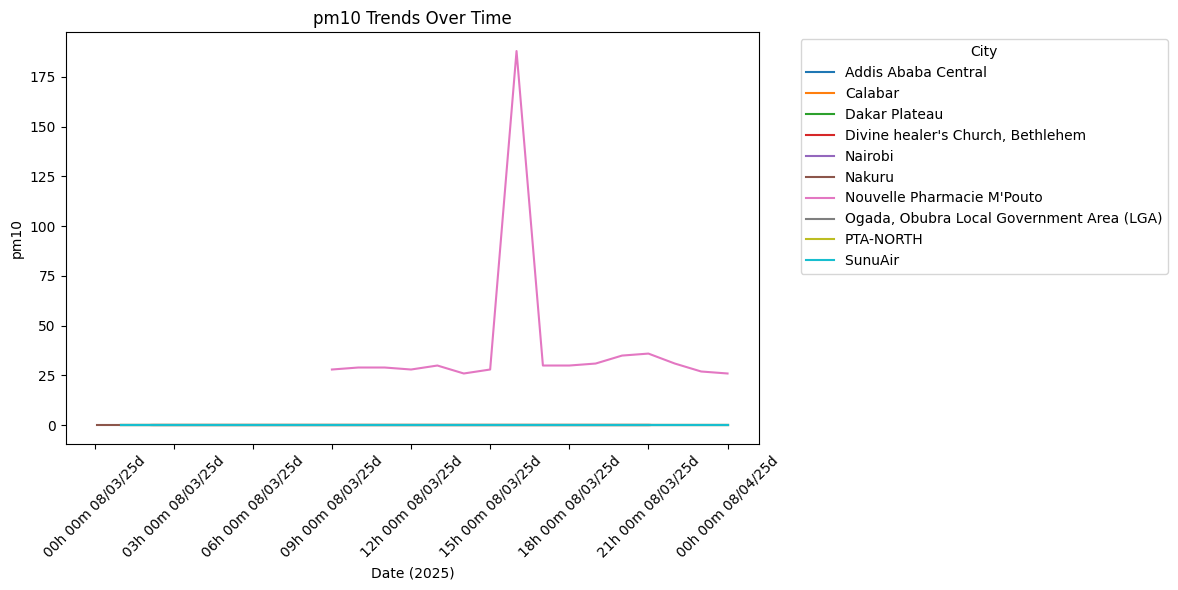

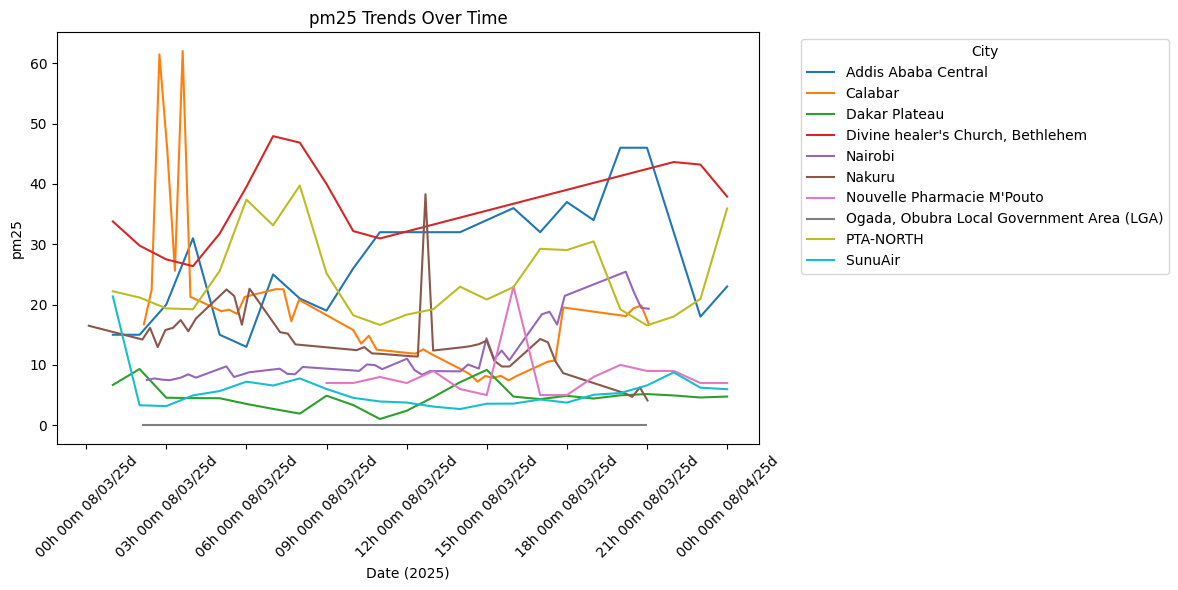

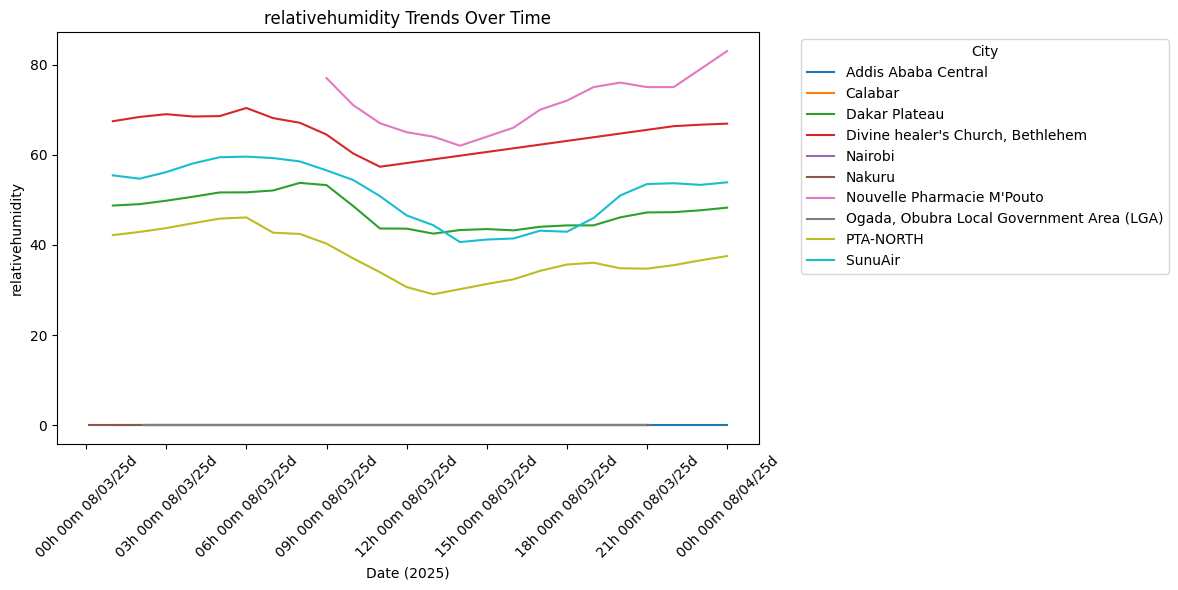

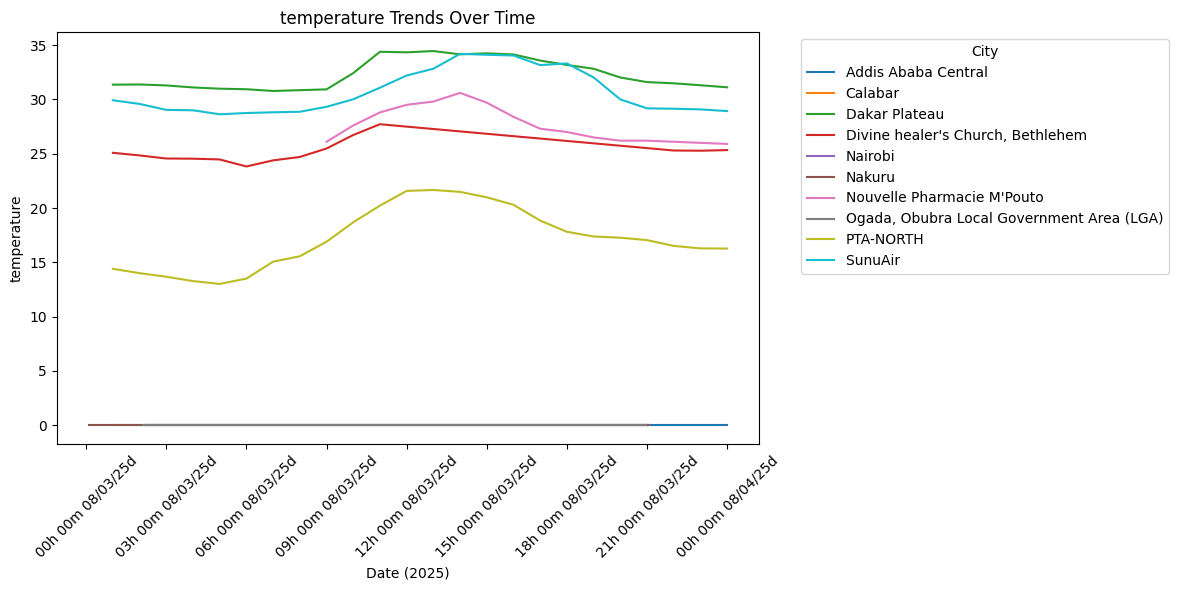

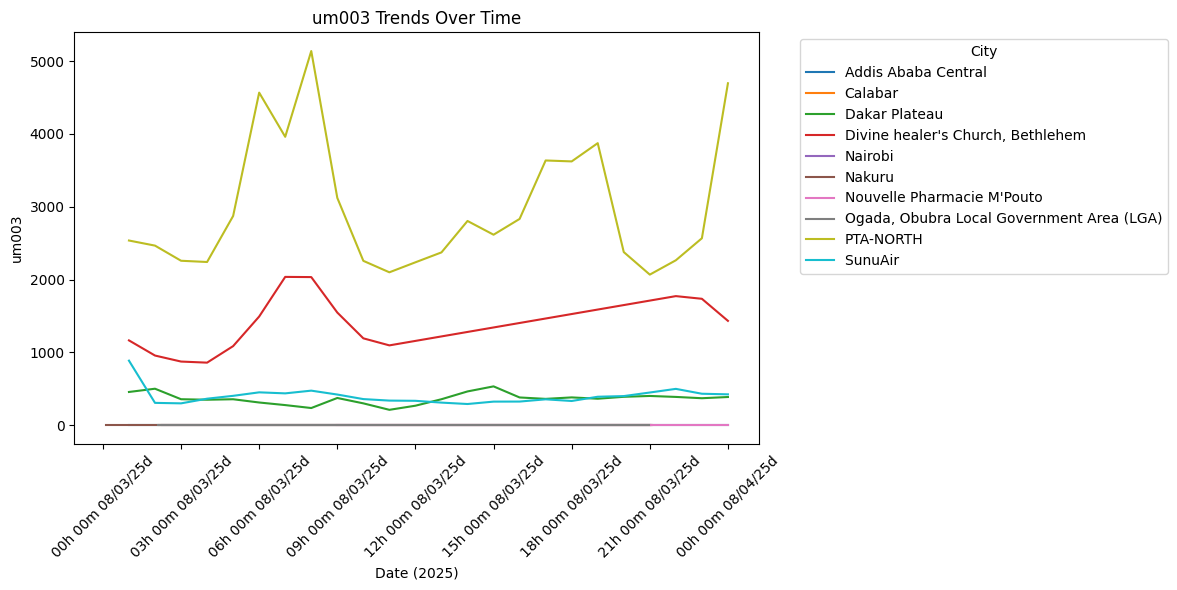

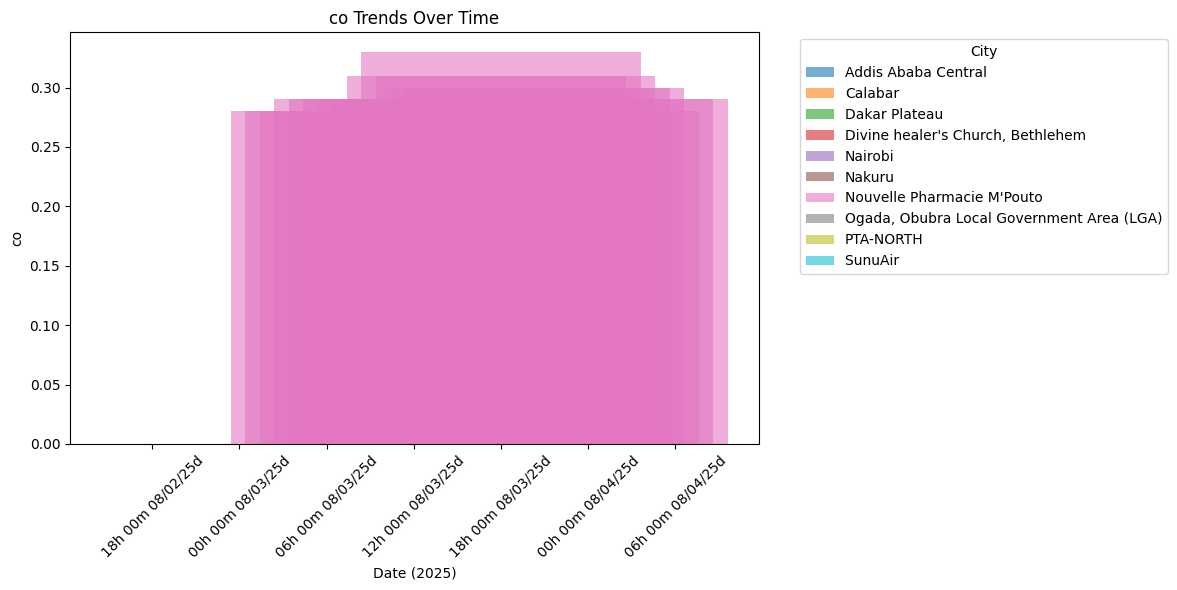

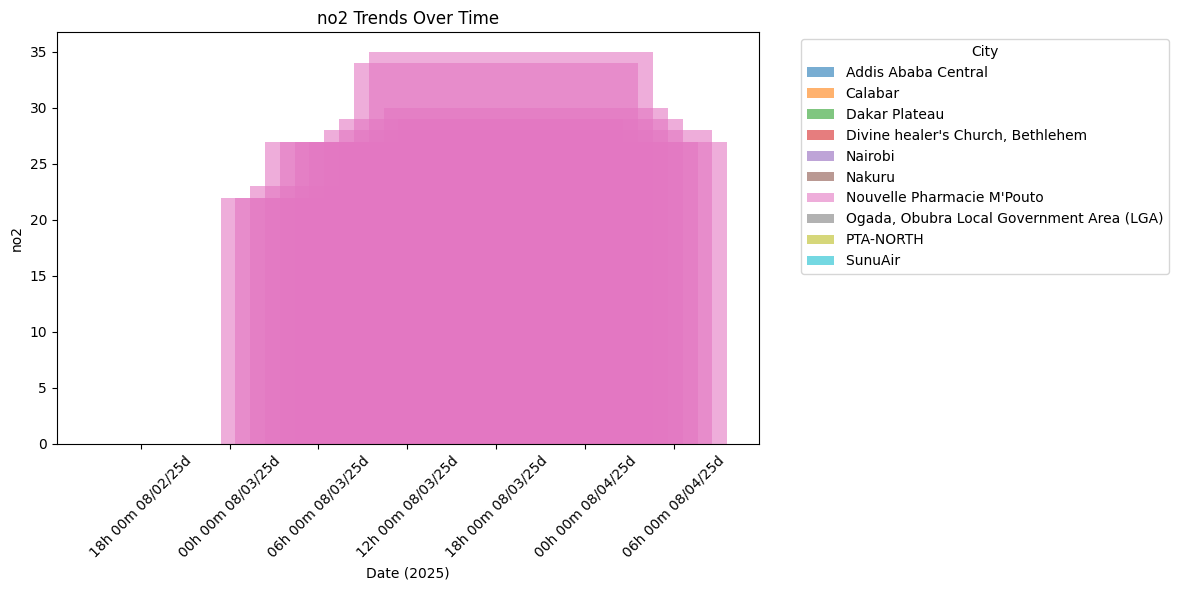

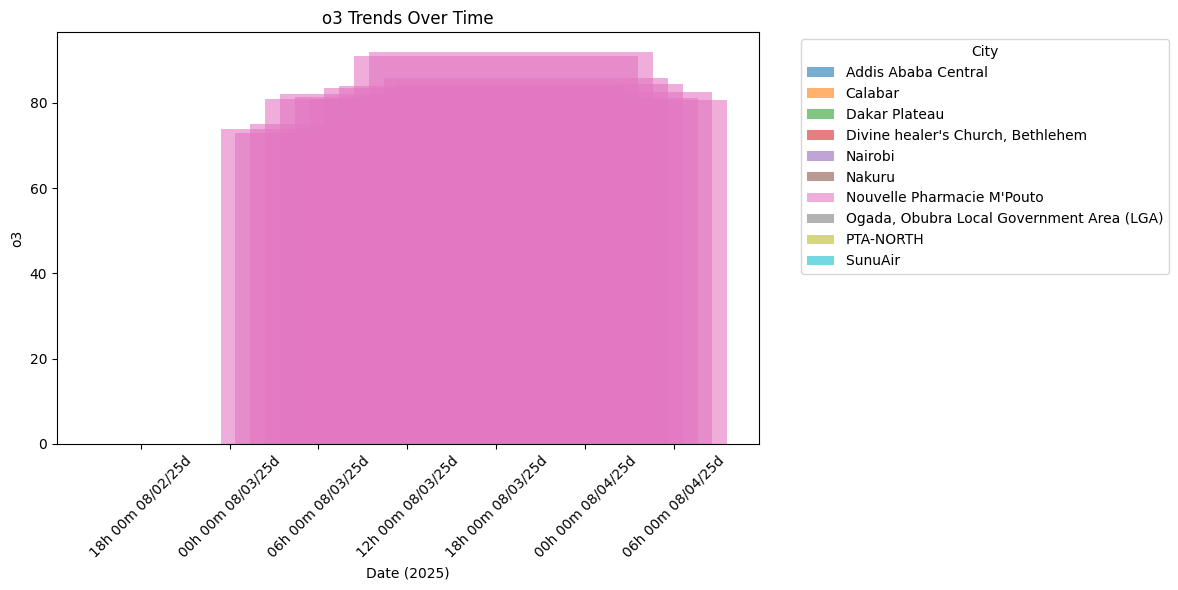

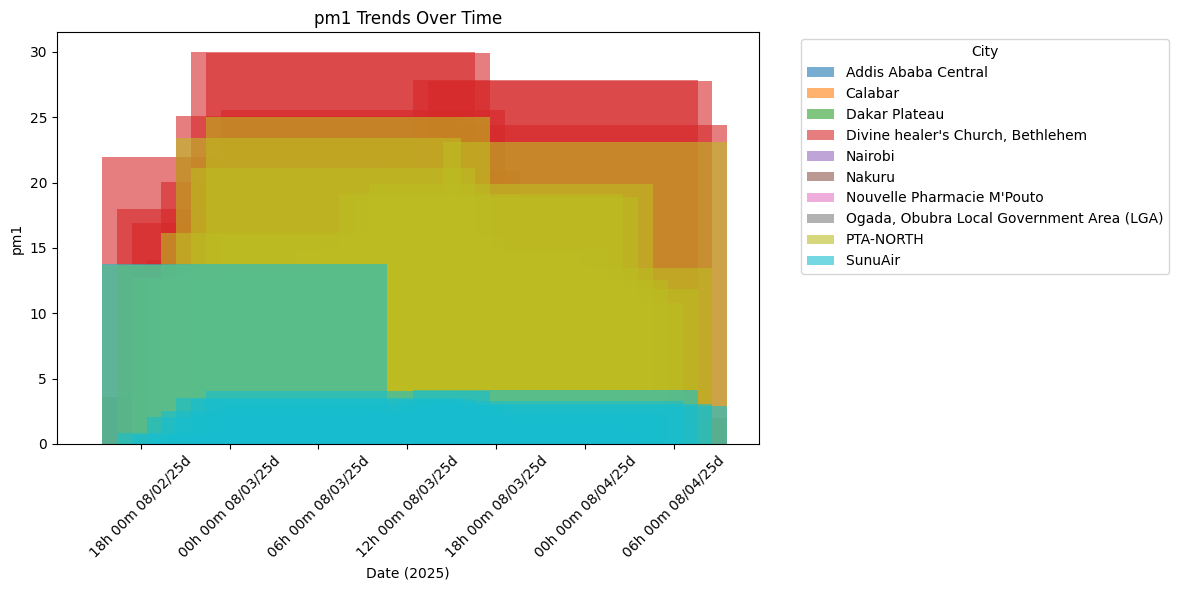

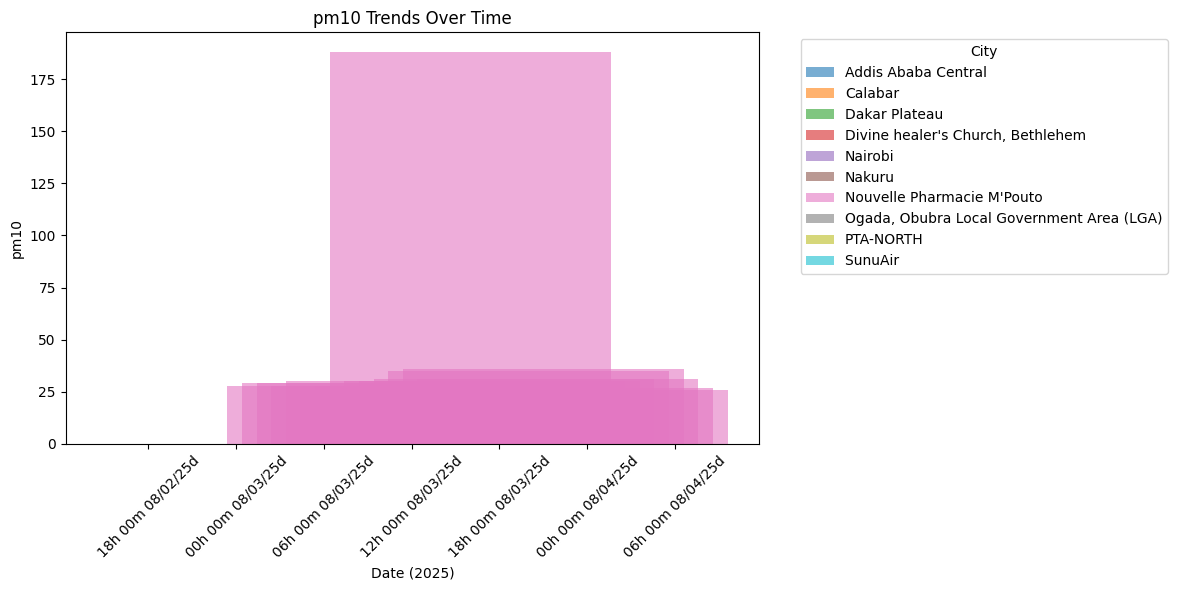

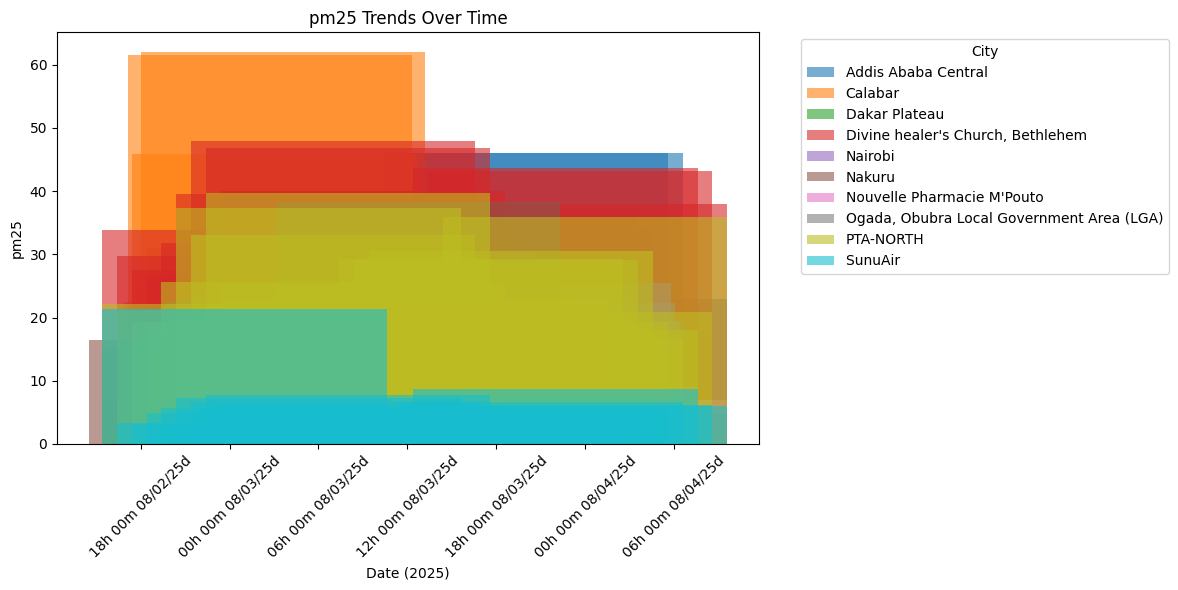

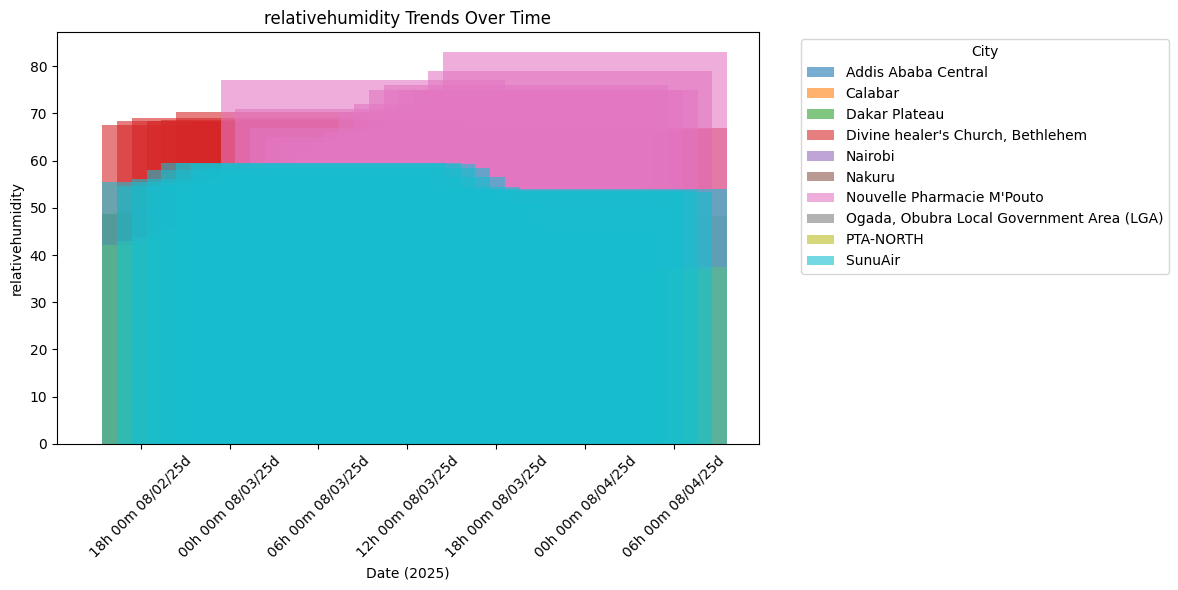

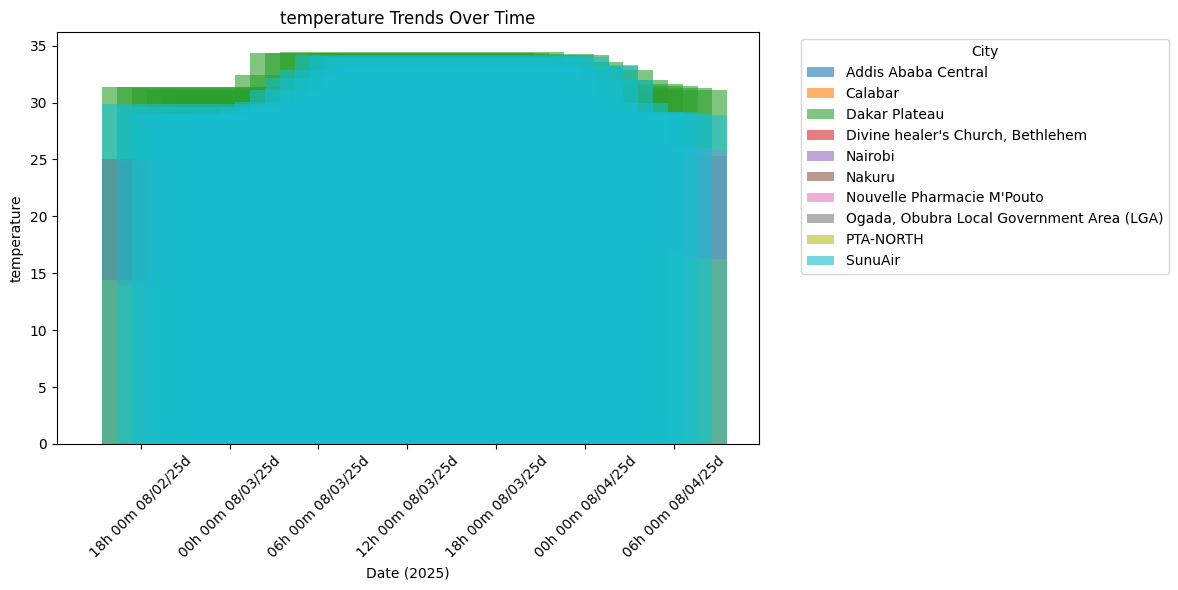

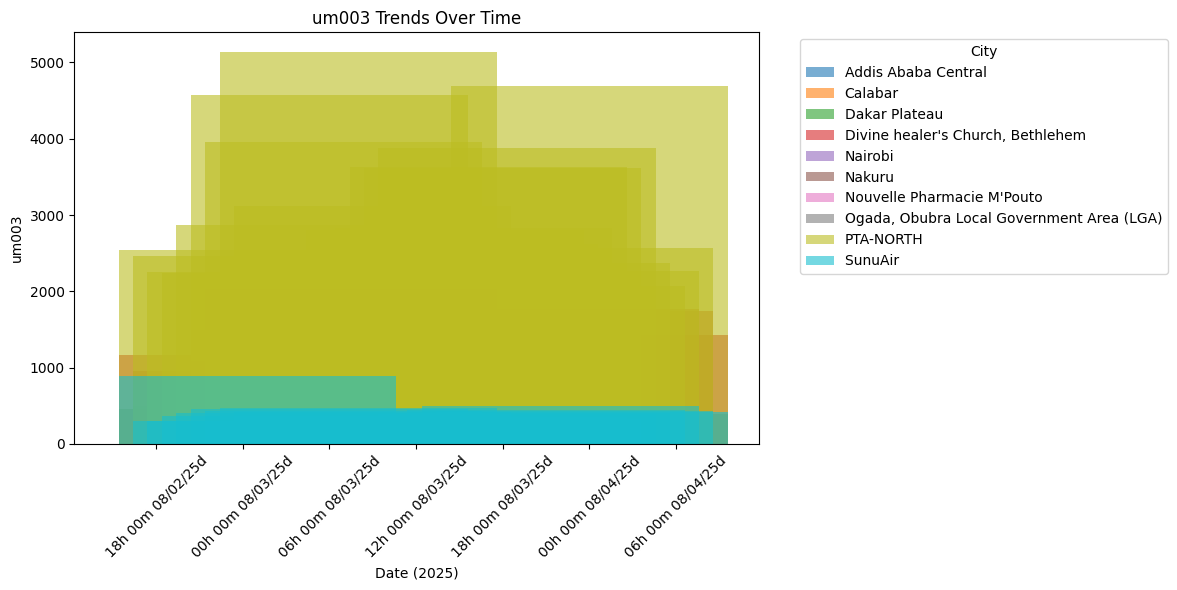

                               location_name             timezone   latitude  \
0  Ogada, Obubra Local Government Area (LGA)         Africa/Lagos   6.066000   
1                                     Nakuru       Africa/Nairobi  -0.267400   
2                                    Calabar         Africa/Lagos   5.025290   
3                                    Nairobi       Africa/Nairobi  -1.331590   
4                                  PTA-NORTH  Africa/Johannesburg -25.681506   
5                             Dakar Plateau       Africa/Ndjamena  14.666253   
6                 Nouvelle Pharmacie M'Pouto       Africa/Abidjan   5.329000   
7          Divine healer's Church, Bethlehem         Africa/Accra   5.704581   
8                                   SunuAir          Africa/Dakar  14.767122   
9                        Addis Ababa Central   Africa/Addis_Ababa   9.058498   

   longitude  
0   8.340000  
1  36.021800  
2   8.348430  
3  36.912710  
4  28.156085  
5  17.441745  
6  -3.949000  

Map(center=[7.5, 10], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_te…

In [9]:
#--- import libraries
#-- Librares for Data Frame & Plotting
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import plotly as ply

#-- Librares for Geographic Map
import geopandas as gpd
import lonboard as lpd
from lonboard import Map, ScatterplotLayer
import ipywidgets as widgets
import leafmap

import os
from glob import glob

# Use notebook's current directory as base
BASE_DIR = os.getcwd()

# Datasets folder inside project
DATASET_DIR = os.path.join(BASE_DIR, "Datasets")

# Input CSV files
files = glob(os.path.join(DATASET_DIR, "*.csv"))

# Outputs folder (optional)
OUTPUT_DIR = os.path.join(BASE_DIR, "outputs")
os.makedirs(OUTPUT_DIR, exist_ok=True)


#--- fetch all csv files
dfs = [pd.read_csv(i) for i in files]
df = pd.concat(dfs, ignore_index=True)

#--- show all rows in df
pd.set_option('display.max_rows', None)  # Show all rows
#print(df)

#---- go back to the original row number
#pd.reset_option('display.max_rows')

#--- exporting the dataFrame to csv to check
df.to_csv(os.path.join(OUTPUT_DIR, "cleaned_air_quality.csv"), index=False)

#--- rearranging the tale for ease (resetting index for understanding as a spreadsheet)
piv_df = pd.pivot_table(
    df,
    values='value',
    index=['location_name', 'datetimeLocal'],  # group by location & time
    columns='parameter'                        # each parameter in its own column
).reset_index()
#print(piv_df)

#--- exporting the piv dataFrame to csv to check
piv_df.to_csv(os.path.join(OUTPUT_DIR, "air_quality_arranged.csv"), index=False)

piv_filled = piv_df.fillna(value = 0)
piv_filled.to_csv(os.path.join(OUTPUT_DIR, "air_quality_filled.csv"), index=False)

#--- filling depending on the data type
"""piv_filled = piv_df.fillna(
    value={col: 0 if pd.api.types.is_numeric_dtype(piv_df[col]) else "" 
           for col in piv_df.columns}
)"""


#--- getting the mean of each parameter
#------- First grouping the rows
group_df = piv_filled.groupby('location_name').mean(numeric_only=True)
#print(group_df.tail(10))
group_df.to_csv(os.path.join(OUTPUT_DIR, "air_quality_grouped.csv"), index=False)

'''#--- Test to see mean of each AQI Parameter Column
mean_co_df = group_df['co'].mean(numeric_only=True)
#print(mean_co_df)'''

#------- Mean of each AQI Parameter Column
mean_dict = {}
for col in group_df.columns:
    mean_dict[col] = group_df[col].mean(numeric_only=True)

#print(mean_dict)

#Picking out the cities with the highest & lowest air quality
city_rank = {}

def get_extreme_cities(df, parameter):
    sorted_df = df.sort_values(by=parameter, ascending=False)
    highest_city = sorted_df.index[0]  # city name
    highest_value = sorted_df[parameter].iloc[0]
    lowest_city = sorted_df.index[-1]
    lowest_value = sorted_df[parameter].iloc[-1]
    
    return {
        "highest_city": highest_city,
        "highest_value": highest_value,
        "lowest_city": lowest_city,
        "lowest_value": lowest_value
    }
#Example with Every parameter
for aqi in group_df.columns:
    city_rank[aqi] = get_extreme_cities(group_df, aqi)
    print(f"\n The Highest & lowest cities as per {aqi}\n", city_rank[aqi])

#--- Example with CO
city_rank["co"] = get_extreme_cities(group_df, "co")
print("\n The Highest & lowest cities as per co\n", city_rank["co"])


#--- Graphs showing AQI Trends overtime
piv_filled["datetimeLocal"] = pd.to_datetime(piv_filled["datetimeLocal"], utc=True) #Converts ISO 8601 timestamp with timezone to Normal Readable Time.
piv_graphed = piv_filled.set_index(["location_name", "datetimeLocal"])

def plot_aqi_trends(df, kind="line"):
    """
    df: DataFrame with MultiIndex (city, date) and AQI columns
    kind: str -> "line", "bar", "scatter", etc.
    """
    for aqi in df.columns:  
        fig, ax = plt.subplots(figsize=(12, 6)) #fresh figure (fig) and a plotting area (ax).
        
        for city in df.index.levels[0]:  # hierarchical index - loop through cities (extracts all unique cities.)
            city_data = df.loc[city][aqi] #label-based indexer - slices the city with the aqi row.
            
            #decision if-elif for picking the kind of graph
            if kind == "line":
                plt.plot(city_data.index, city_data.values, label=city)
            elif kind == "bar":
                plt.bar(city_data.index, city_data.values, label=city, alpha=0.6)
            elif kind == "scatter":
                plt.scatter(city_data.index, city_data.values, label=city)
            else:
                raise ValueError("Unsupported plot kind. Use 'line', 'bar', or 'scatter'.")
        
        # Format X-axis dates
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())  #auto chooses the ticks/gaps for the x-axis
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%Hh %Mm %Dd")) #converts tick labels & Shows as hour, month & year
 
        plt.xticks(rotation=45) #rotates the axis of the label so it doesn't overlap

        
        ax.set_title(f"{aqi} Trends Over Time") 
        ax.set_xlabel("Date (2025)")
        ax.set_ylabel(aqi)
        ax.legend(title="City", bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()

        
#Example Test
plot_aqi_trends(piv_graphed, kind="line")
plot_aqi_trends(piv_graphed, kind="bar")

#--- Geographic Representation

stations = (
    df[["location_name", "timezone", "latitude", "longitude"]]
    .drop_duplicates()       # remove duplicates
    .reset_index(drop=True)  # clean up index
)
print(stations)

latest_aqi = piv_filled.sort_values("datetimeLocal").groupby("location_name").tail(1)
map_data = stations.merge(latest_aqi, on="location_name", how="left")

#--Mapping with leafmap (Interactive Map)

m = leafmap.Map(center=[7.5, 10], zoom=3) #builds the map on Africa

# Add points to map
for _, row in map_data.iterrows(): #Builds the pop-up
    popup_text = f"""{row['location_name']}<b><br>
    ({row['timezone']})<br>
    CO: {row['co']} µg/m³<br>
    NO₂: {row['no2']} µg/m³<br>
    O₃: {row['o3']} µg/m³<br>
    PM1: {row['pm1']} µg/m³<br>
    PM10: {row['pm10']} µg/m³<br>
    PM2.5: {row['pm25']} µg/m³<br>
    Humidity: {row['relativehumidity']} %<br>
    Temp: {row['temperature']} °C<br>
    Date: {row['datetimeLocal']}"""
    
    popup_widget = widgets.HTML(value=popup_text)            # <-- wrap the HTML string in an ipywidget
    m.add_marker(location=[row['latitude'], row['longitude']], popup=popup_widget)

m #returns the map

In [11]:
import folium
from folium.plugins import MarkerCluster

# center the map roughly over your stations
m2 = folium.Map(location=[6.5, 8.0], zoom_start=4, tiles="CartoDB positron")

mc = MarkerCluster().add_to(m2)

for _, row in map_data.iterrows():
    popup_html = f"""
    <div style="font-family: Arial; font-size:12px; max-width:300px;">
      <b>{row['location_name']}</b><br>
      <small>{row.get('timezone','')}</small>
      <hr style="margin:6px 0">
      <table style="font-size:12px;">
        <tr><td><b>PM2.5</b></td><td>{row.get('pm25','N/A')}</td></tr>
        <tr><td><b>PM10</b></td><td>{row.get('pm10','N/A')}</td></tr>
        <tr><td><b>NO2</b></td><td>{row.get('no2','N/A')}</td></tr>
        <!-- add more rows as desired -->
      </table>
    </div>
    """

    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=7,
        color='crimson',
        fill=True,
        fill_opacity=0.7,
        popup=folium.Popup(popup_html, max_width=350)
    ).add_to(mc)

# Save to disk and open in browser
out_file = os.path.join(OUTPUT_DIR, "aq_map.html")
m2.save(out_file)
print("Saved map to:", out_file)

Saved map to: C:\Users\USR P\Documents\DataSci\Air Quality Index\outputs\aq_map.html
